# (A) ANOMALY DETECTION 

### Introduction

**What are anomalies in IoT data?** 
- Sensor prototypes deployed under potentially harsh weather conditions for tasks like environmental forecasting are prone to breakage and damage.The main result of this kind of deployment is the presence of anomalies in the data collected.
- Anomaly detection is therefore an important steps in various IoT applications since it helps in getting rid of the anomalies.

**Clustering**
- clustering is one of the most common unsurpervised machine learning technique used to get an intuition/understanding about the structure of a certain dataset.
- **Definition** : Like the name states, it can be defined as the task of indentifying sub-groups(clusters) in a dataset
- **The catch** : Datapoints in the same cluster are very similar, while datapoints in diffrent clusters are very diffrent
- **Application** : Clustering algorithms e.g. **KMeans**, can be used in Anomaly detection - *ASSUMPTION* - THE CLUSTERS WITH THE FEW DATAPOINTS ARE THE ANOMALOUS CLUSTERS, THE MAIN CLUSTER HAS THE CORRECT DATAPOINTS
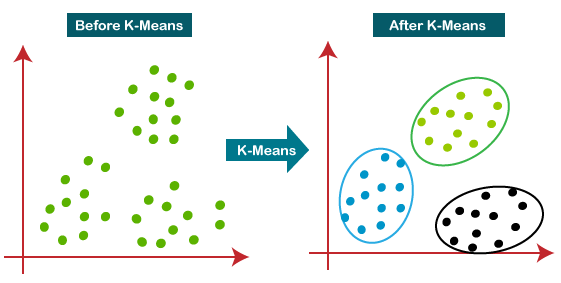
    - **Image source:[kmeans clustering](https://www.analyticsvidhya.com/blog/2021/04/k-means-clustering-simplified-in-python/)**

**KMeans**
- KMeans is a Clustering based – Unsupervised machine learning technique used to identify clusters of data objects in a dataset. 
- Among many clustering methods, KMeans is one of the oldest and most approachable. These trait makes KMeans implementation in Python easy and straightforward.
- **STEPS FOLLOWED** 
1. Specify number of clusters K.
2. Initialize centroids by first shuffling the dataset and then randomly selecting K data points for the centroids without replacement.
3. Keep iterating until there is no change to the centroids. i.e assignment of data points to clusters isn’t changing.
4. Compute the sum of the squared distance between data points and all centroids.
5. Assign each data point to the closest cluster (centroid).
6. Compute the centroids for the clusters by taking the average of the all data points that belong to each cluster.

**KMeans Algorithm**

**Generate a sample dataset** 
 - We will generate and plot 20 data points from a mixture of 2 Gaussians (10 data points from each component).

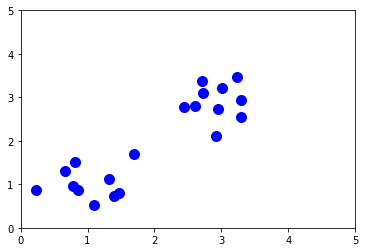

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

#Set the random seed for reproducability
np.random.seed(123)

#Generate the data
X1 = np.random.multivariate_normal(np.array([1, 1]), np.diag([.1, .1]), 10)#10 points from the first GMM component
X2 = np.random.multivariate_normal(np.array([3,3 ]), np.diag([.1, .1]), 10)#10 points from the second GMM component
X = np.concatenate((X1, X2))

#Plot the data
plt.plot(X[:, 0], X[:, 1], 'bo', markersize=10)
plt.xlim([0, 5]);
plt.ylim([0, 5]);

##### KMeans from scikit learn to group the datapoints and output the data features 

1. Cluster_center_co-ordinates 

[[2.91582997 2.90633719]
 [1.03277733 1.0395868 ]] 

2. Datapoint_labels 

[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]


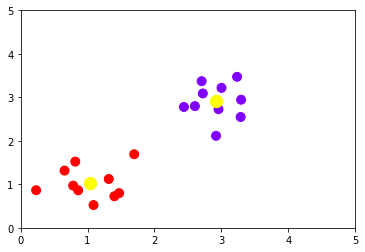

In [2]:
clusters = 2 # number of clusters
X_clusters= KMeans(n_clusters = clusters, random_state = 123).fit(X) # fitting the data
print('1. Cluster_center_co-ordinates \n')
print( X_clusters.cluster_centers_, '\n') #cluster centers
print('2. Datapoint_labels \n')
print(X_clusters.labels_) #cluster labels
centroids = pd.DataFrame(X_clusters.cluster_centers_, columns = ["x1", "x2"])
plt.scatter(X[:, 0], X[:, 1], c = X_clusters.labels_ , cmap = 'rainbow', s = 80)
plt.scatter(centroids['x1'],centroids['x1'],s = 150,c = 'yellow')
plt.xlim([0, 5]);
plt.ylim([0, 5]);

In [3]:
y_pred = X_clusters.fit_predict([[0.5, 0.5], [3.2, 3.2], [0.8, 0.8] ]) # predict the clusters for some datapoints
y_pred

array([0, 1, 0])

## Using Kmeans to detect anomalies in IoT sensor data (River water level data)

#### BREAKDOWN
- We will import a section of the dataset streaming in. (prepared sample)
- Extract data from a single day(at random)(make sure there are anomalie)
- Use KMeans to perform the anomaly detection
- Calculate the daily mean

#### Lets dive in!!!! 


####  1. Import the necessary packages 

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
plt.rcParams['figure.figsize'] = (18, 9)

#### 2. Import the dataset and visualize it
This is Water Level data collected between the 11th of June 2021 and 16th of June 2021. It is an interesting piece data I have been collecting from one of the water_level sensors along River Muringato in Nyeri- Kenya

<function matplotlib.pyplot.show(close=None, block=None)>

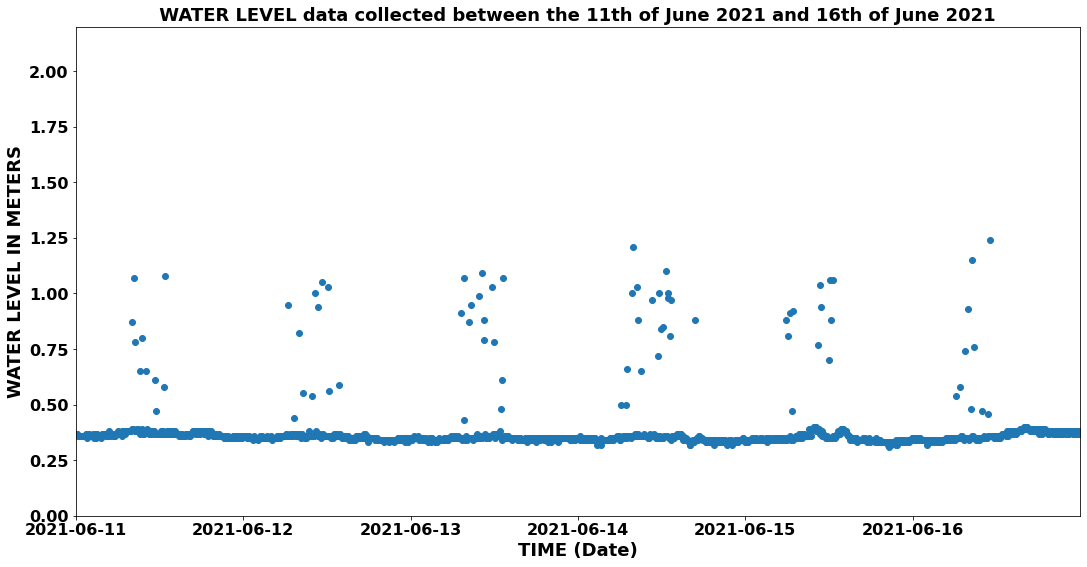

In [5]:
df = pd.read_csv('data/sample_dataset_waterlevel.csv')
df[['time']] = df[['time']].apply(pd.to_datetime)
plt.scatter(df['time'],df['Data'])
plt.title(' WATER LEVEL data collected between the 11th of June 2021 and 16th of June 2021 ',weight = 'bold', fontsize=18)
plt.xlabel('TIME (Date)', fontsize = 18, weight = 'bold')
plt.ylabel('WATER LEVEL IN METERS', fontsize = 18, weight = 'bold')
plt.xlim(['2021-06-11 00:00:00'],['2021-06-16 23:59:59'])
plt.ylim(0, 2.2)
plt.xticks(fontsize = 16, weight = 'bold')
plt.yticks(fontsize = 16, weight = 'bold')
plt.rcParams['figure.figsize'] = (18, 9)
plt.show

#### 4. Clustering the whole dataset 

####  silhouette_score 

- used to evaluate the optimum number of clusters needed for a particular dataset by determining the degree of separation between clusters. For each datapoint  $\alpha$:
    - **Compute the average distance from all data points in the same cluster $a(\alpha)$**
    - **Compute the average distance from all data points in the closest cluster $b(\alpha)$**
    - **Compute the silhouette_score - formula : $$ S(\alpha) = \frac{b(\alpha)- a(\alpha)}{max[a(\alpha)- b(\alpha)]} \\ $$**
- The coefficient can take values in the interval [-1, 1].
    - If it is 0 –> the datapoint is very close to the neighboring clusters (overlapping clusters).
    - It it is 1 –> the datapoint is far away from the neighboring clusters.
    - It it is -1 –> the datapoint is assigned to the wrong clusters.
- Therefore, we want the coefficients to be as big as possible and close to 1 to have a good cluster. 


In [6]:
# silhouette_score is used to evaluate the optimum number of clusters needed for a particular dataset
water_level_array = np.array(df['Data']).reshape(-1, 1) # convert the dataframe column to an array and reshape it.
from sklearn.metrics import silhouette_samples, silhouette_score # import silhouette_samples, silhouette_score 
kmax = 10 # set the maximum number of clusters - running iterations
for k in range(2, kmax+1): # for loop to run the iterations and spit out the results
    kmeans = KMeans(n_clusters = k).fit(water_level_array) # Fitting the dataset in Kmeans 
    labels = kmeans.labels_ #Production of cluster labels
    silhouette_avg = silhouette_score(water_level_array, labels, metric = 'euclidean') # euclidean distance from the centre 
    print("For k_clusters =", k, "The average silhouette_score is :", silhouette_avg) # score and cluster
    sample_silhouette_values = silhouette_samples(water_level_array,labels)
    # select the k_clusters with the highest silhoutte_score == Hence k = 2


For k_clusters = 2 The average silhouette_score is : 0.9521420206357991
For k_clusters = 3 The average silhouette_score is : 0.9270189941819424
For k_clusters = 4 The average silhouette_score is : 0.8963835200772104
For k_clusters = 5 The average silhouette_score is : 0.6255334283204603
For k_clusters = 6 The average silhouette_score is : 0.6337589236634423
For k_clusters = 7 The average silhouette_score is : 0.6357900117491869
For k_clusters = 8 The average silhouette_score is : 0.6774262261963516
For k_clusters = 9 The average silhouette_score is : 0.6820279569091114
For k_clusters = 10 The average silhouette_score is : 0.681289964550424


#### 5. Plotting the diffrent clusters 

<function matplotlib.pyplot.show(close=None, block=None)>

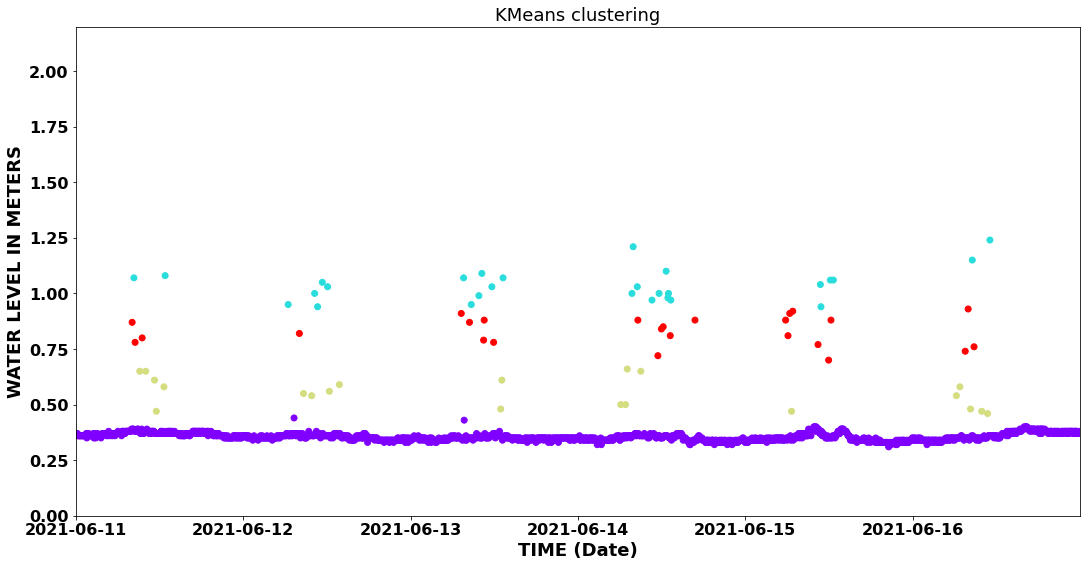

In [7]:
num_of_clusters = 4 # number of clusters
water_level_pred = KMeans(n_clusters = num_of_clusters, random_state = 123).fit(water_level_array) # fitting the data
plt.scatter(df['time'],water_level_array, c = water_level_pred.labels_, cmap = 'rainbow') # plotting
plt.title('KMeans clustering', fontsize = 18)
plt.xlabel('TIME (Date)', fontsize = 18, weight = 'bold')
plt.ylabel('WATER LEVEL IN METERS', fontsize = 18, weight = 'bold')
plt.xlim(['2021-06-11 00:00:00'],['2021-06-16 23:59:59'])
plt.ylim(0, 2.2)
plt.xticks(fontsize = 16, weight = 'bold')
plt.yticks(fontsize = 16, weight = 'bold')
plt.rcParams['figure.figsize'] = (18, 9)
plt.show

c:\users\folio\iot-env\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


1617 0.3546815089672232
28 1.0382142857142855
21 0.5523809523809524
25 0.8311999999999999


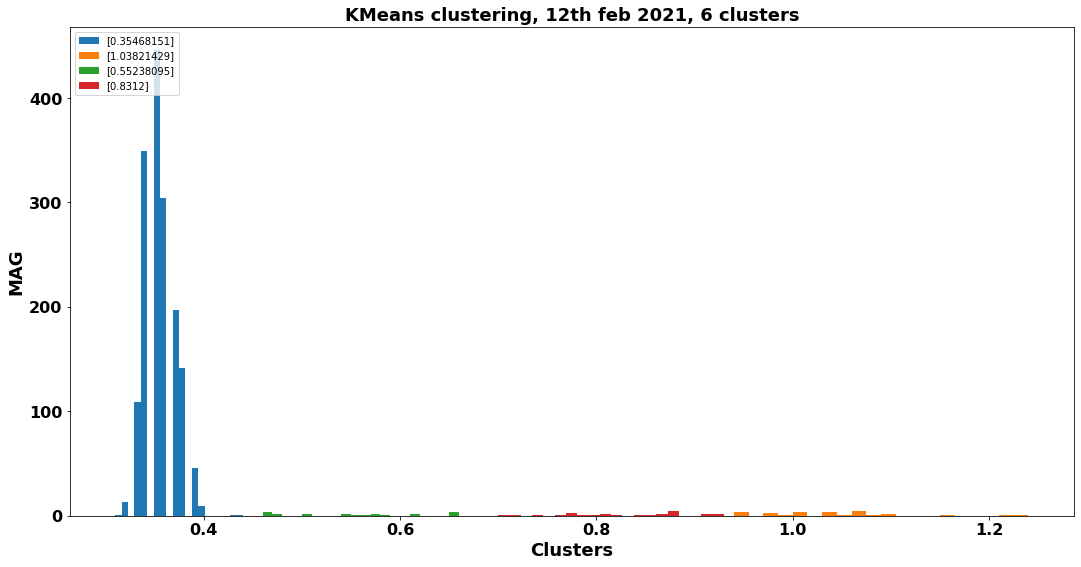

In [8]:
num_of_clusters = 4
water_level_pred2 = KMeans(n_clusters = num_of_clusters, random_state = 123).fit_predict(water_level_array)
plt.figure()
for indx in range (num_of_clusters):
    water_level_clusters = water_level_array[water_level_pred2 == indx]
    plt.hist(water_level_clusters, 20);
    plt.title('KMeans clustering, 12th feb 2021, 6 clusters', fontsize = 18, weight = 'bold')
    plt.xlabel('Clusters', fontsize = 18, weight = 'bold')
    plt.ylabel('MAG', fontsize = 18, weight = 'bold')
    plt.xticks(fontsize = 16, weight = 'bold')
    plt.yticks(fontsize = 16, weight = 'bold')
    plt.legend(water_level_pred.cluster_centers_, loc = "upper left")
    print(len(water_level_clusters), water_level_clusters.mean())

#### 6. Getting rid of the anomalies and plotting the clean curve 
- **REMINDER** - **The dominant cluster contain the cluster with the correct data points, the rest are anomalous**

<function matplotlib.pyplot.show(close=None, block=None)>

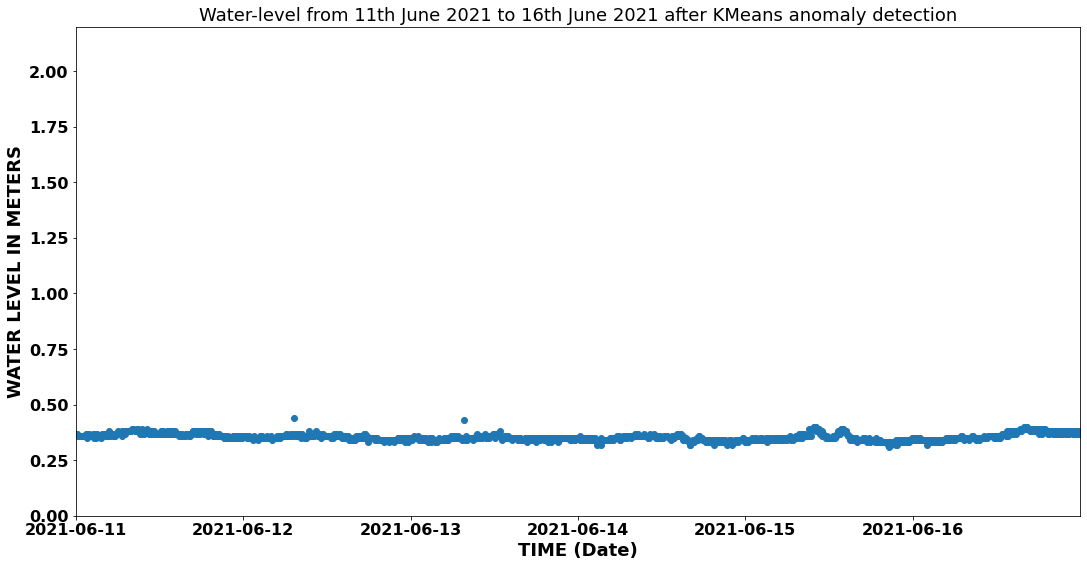

In [9]:
#clean dataset
majority_index = (max(set(list(water_level_pred2)), key = list(water_level_pred2).count))
kmeans_index = list(water_level_pred2)
df['kmeans_index'] = kmeans_index
df_clean = df.drop(df[df.kmeans_index != majority_index].index)
df_clean = df_clean.drop(['airtime', 'coding_rate', 'data_rate', 'frequency', 'gateway', 'rssi', 'sensor', 'snr', 'kmeans_index'], axis = 1)

#plotting
plt.scatter(df_clean['time'],df_clean['Data']) # plotting
plt.title('Water-level from 11th June 2021 to 16th June 2021 after KMeans anomaly detection', fontsize=18)
plt.xlabel('TIME (Date)', fontsize = 18, weight = 'bold')
plt.ylabel('WATER LEVEL IN METERS', fontsize = 18, weight = 'bold')
plt.xlim(['2021-06-11 00:00:00'],['2021-06-16 23:59:59'])
plt.ylim(0, 2.2)
plt.xticks(fontsize = 16, weight = 'bold')
plt.yticks(fontsize = 16, weight = 'bold')
plt.rcParams['figure.figsize'] = (18, 9)
plt.show

#### 7. Calculating the mean 

In [10]:
df_clean_mean = df_clean.groupby(df_clean.time.dt.date).mean()
df_clean_mean = df_clean_mean.reset_index()
df_clean_mean

,time,Data
0,2021-06-11,0.368431
1,2021-06-12,0.353443
2,2021-06-13,0.348657
3,2021-06-14,0.346160
4,2021-06-15,0.348819
5,2021-06-16,0.362201


#### 8. Plotting the mean

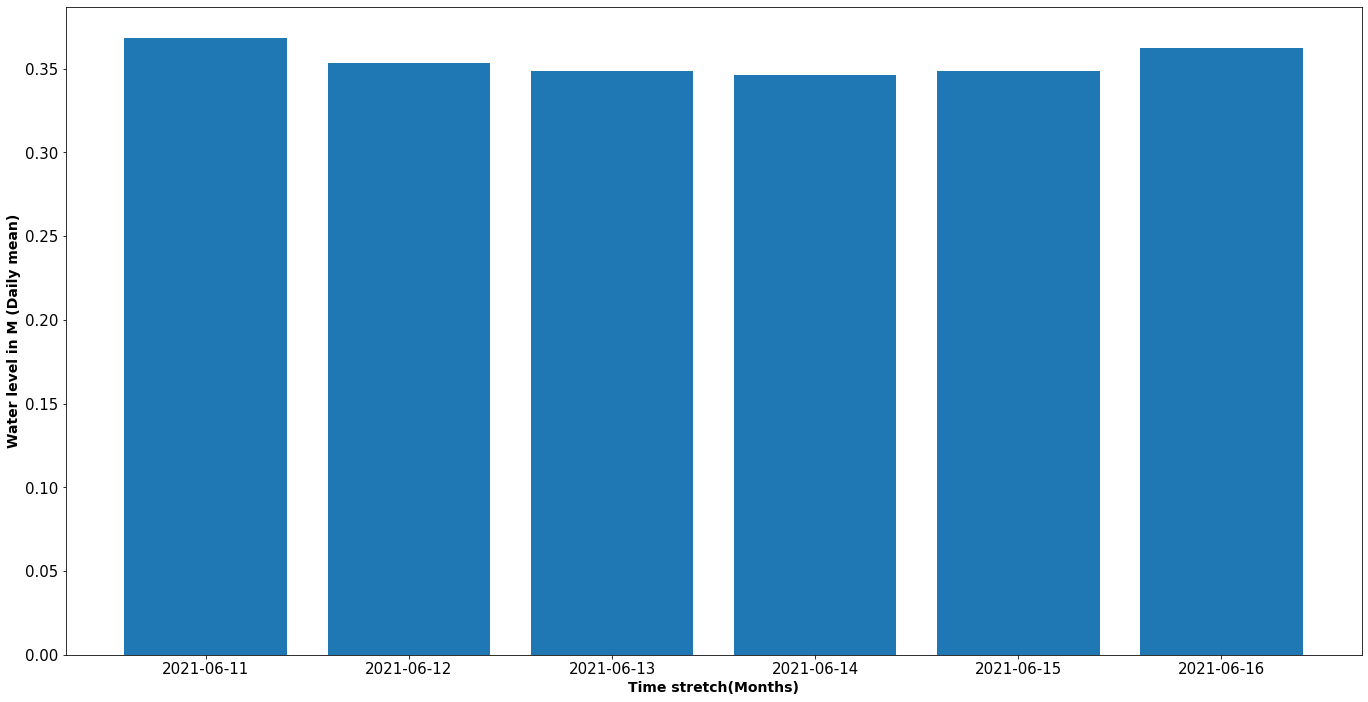

In [11]:
#Daily Mean
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_clean_mean['time'],df_clean_mean['Data'])
ax.set_xlabel('Time stretch(Months)', fontsize = 14, weight = 'bold')
ax.set_ylabel('Water level in M (Daily mean)',fontsize = 14, weight = 'bold')
ax.tick_params(axis = 'y', labelsize = 15,)
ax.tick_params(axis = 'x', labelsize = 15,)
plt.show()

# (B) Comparison with Other Relevant Datasets
- In this section we will compare our water level data with rainfall data from TAHMO
- TAHMO(Trans-African Hydro-Meteorological Observatory (TAHMO))

In [12]:
#read the data
import matplotlib.pyplot as plt
df_watertrend = pd.read_csv('data/muringato-sept.csv')
df_rainfalltrend = pd.read_csv('data/rainfall_data.csv')

C:\Users\Folio\AppData\Local\Temp/ipykernel_9048/2631148149.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(df_rainfalltrend['timestamp (UTC)'], fontsize = 10, weight = 'bold')


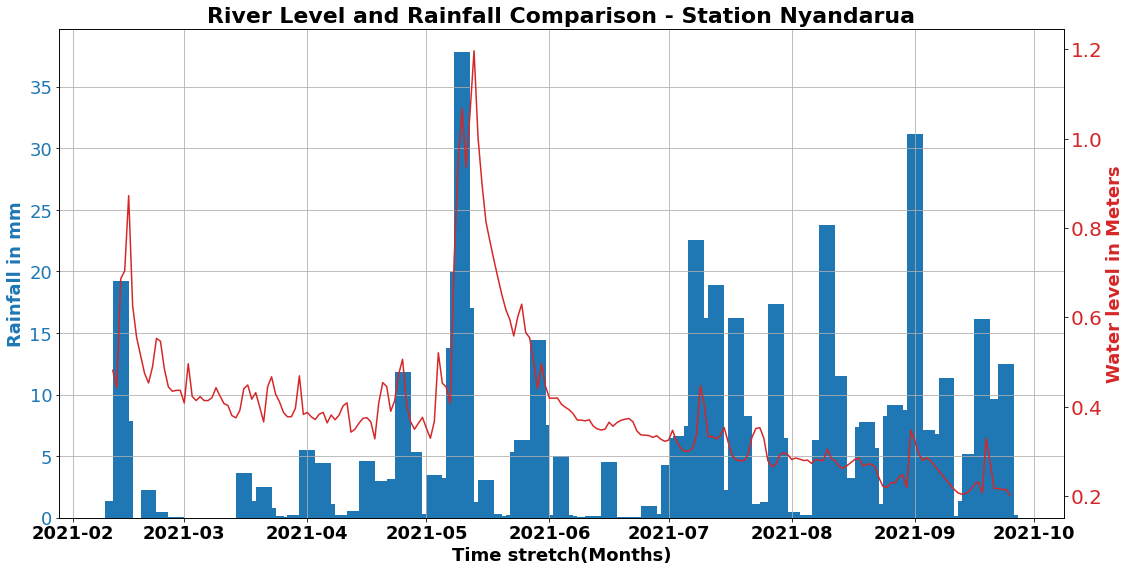

In [13]:
# plotting
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Rainfall (mm)', color = color)  # we already handled the x-label with ax1
ax1.bar(pd.to_datetime(df_rainfalltrend['timestamp (UTC)']), df_rainfalltrend['precipitation (mm)'], color = color, width = 4)
ax1.tick_params(axis = 'y', labelcolor = color)
ax1.grid(True)
ax1.set_xlabel('Time stretch(Months)', fontsize = 18, weight = 'bold')
ax1.set_ylabel('Rainfall in mm',fontsize = 18, weight = 'bold')
ax1.set_xticklabels(df_rainfalltrend['timestamp (UTC)'], fontsize = 10, weight = 'bold')
ax1.tick_params(axis = 'y', labelsize = 18)
ax1.tick_params(axis = 'x',which = 'major', labelsize = 18)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('River Level (m)', color = color)
ax2.plot(pd.to_datetime(df_rainfalltrend['timestamp (UTC)']), df_watertrend['Data'], color = color)
ax2.tick_params(axis = 'y', labelcolor=color)
ax2.set_xlabel('Time stretch(Months)', fontsize = 18, weight = 'bold')
ax2.set_ylabel('Water level in Meters',fontsize = 18, weight = 'bold')
ax2.tick_params(axis = 'y', labelsize = 20)
#ax1.tick_params(axis = 'x', rotation = 90)
plt.title('River Level and Rainfall Comparison - Station Nyandarua', fontsize = 22, weight = 'bold')
#plt.xticks(rotation = 90)
plt.show()